### Import libriaries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

### Load Data

In [31]:
# load trainng and test data 
data_train = pd.read_csv('basket_data_by_date_train.csv')

data_test = pd.read_csv('basket_data_by_date_test.csv')

data_train.head()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,cost
0,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,1/12/2010 8:26,3.39,17850,20.34
1,536365,GLASS STAR FROSTED T-LIGHT HOLDER,6,1/12/2010 8:26,4.25,17850,25.50
2,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,1/12/2010 8:26,2.55,17850,15.30
3,536365,RED WOOLLY HOTTIE WHITE HEART.,6,1/12/2010 8:26,3.39,17850,20.34
4,536365,SET 7 BABUSHKA NESTING BOXES,2,1/12/2010 8:26,7.65,17850,15.30


In [27]:
data_test.head()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,cost
0,544398.0,JUMBO SHOPPER VINTAGE RED PAISLEY,1.0,18/02/2011 12:27,1.95,15311.0,1.95
1,544398.0,ZINC WILLIE WINKIE CANDLE STICK,4.0,18/02/2011 12:27,0.85,15311.0,3.40
2,544398.0,LOVE BUILDING BLOCK WORD,2.0,18/02/2011 12:27,5.95,15311.0,11.90
3,544398.0,HANGING FAIRY CAKE DECORATION,3.0,18/02/2011 12:27,2.10,15311.0,6.30
4,544398.0,RED HEART SHAPE LOVE BUCKET,1.0,18/02/2011 12:27,2.95,15311.0,2.95


In [32]:
data_test.shape

(40000, 7)

In [33]:
data_test.isnull().sum()

BillNo        30000
Itemname      30000
Quantity      30000
Date          30000
Price         30000
CustomerID    30000
cost          30000
dtype: int64

In [34]:
data_test = data_test[~data_test["BillNo"].isnull()]

In [35]:
data_test.isnull().sum()

BillNo        0
Itemname      0
Quantity      0
Date          0
Price         0
CustomerID    0
cost          0
dtype: int64

In [42]:
data_test.head()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,cost
0,544398.0,JUMBO SHOPPER VINTAGE RED PAISLEY,1.0,18/02/2011 12:27,1.95,15311.0,1.95
1,544398.0,ZINC WILLIE WINKIE CANDLE STICK,4.0,18/02/2011 12:27,0.85,15311.0,3.40
2,544398.0,LOVE BUILDING BLOCK WORD,2.0,18/02/2011 12:27,5.95,15311.0,11.90
3,544398.0,HANGING FAIRY CAKE DECORATION,3.0,18/02/2011 12:27,2.10,15311.0,6.30
4,544398.0,RED HEART SHAPE LOVE BUCKET,1.0,18/02/2011 12:27,2.95,15311.0,2.95


In [40]:
data_test['CustomerID'].astype(int)

0       15311
1       15311
2       15311
3       15311
4       15311
        ...  
9995    14112
9996    14112
9997    14112
9998    14112
9999    14112
Name: CustomerID, Length: 10000, dtype: int64

In [38]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   BillNo      10000 non-null  float64
 1   Itemname    10000 non-null  object 
 2   Quantity    10000 non-null  float64
 3   Date        10000 non-null  object 
 4   Price       10000 non-null  float64
 5   CustomerID  10000 non-null  float64
 6   cost        10000 non-null  float64
dtypes: float64(5), object(2)
memory usage: 625.0+ KB


### Analyse and Pre-process Data

In [11]:
print('Shape of data:', data_train.shape)

Shape of data: (40000, 7)


In [12]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   BillNo      40000 non-null  int64  
 1   Itemname    40000 non-null  object 
 2   Quantity    40000 non-null  int64  
 3   Date        40000 non-null  object 
 4   Price       40000 non-null  float64
 5   CustomerID  40000 non-null  int64  
 6   cost        40000 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 2.1+ MB


Checking the missing values in data:

In [13]:
data_train.isnull().sum()

BillNo        0
Itemname      0
Quantity      0
Date          0
Price         0
CustomerID    0
cost          0
dtype: int64

In [14]:
data_train["Itemname"].nunique()

2523

In [15]:
data_train["CustomerID"].nunique()

1391

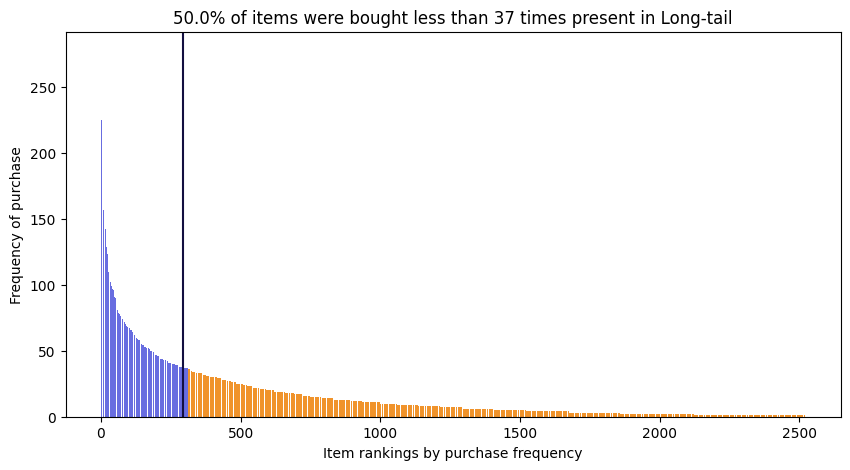

In [16]:
# getting frequency of items bought
item_frequency = data_train["Itemname"].value_counts()

# identifying threshold for 50% of total items bought by item rankings
buying_threshold = 0.5
cumulative_freq_products = np.cumsum(item_frequency)
popularity_threshold_item = len(cumulative_freq_products[cumulative_freq_products < item_frequency.sum()*buying_threshold])
popularity_threshold = item_frequency[popularity_threshold_item+1]


# Setting figure size and ploting the count using a bar chart
fig, ax = plt.subplots(figsize=(10,5), dpi=100)

# Setting color for popular and unpopular items
popular_color = 'red'
unpopular_color = 'black'


# Plotting the count of each unique item by separting them with refrence to popularity threshold
for i in range(len(item_frequency)):
    if item_frequency[i] >= popularity_threshold:
        ax.bar(i, item_frequency[i], color="#686de0")
    else:
        ax.bar(i, item_frequency[i], color="#f0932b")

# Setting labels and title
ax.set_xlabel('Item rankings by purchase frequency')
ax.set_ylabel('Frequency of purchase')
ax.set_title(f'{(1-buying_threshold)*100}% of items were bought less than {popularity_threshold} times present in Long-tail')

# adding a horizontal line to separate popular and unpopular items
n_popular_items = sum(item_frequency > popularity_threshold)
ax.axvline(x=n_popular_items, color="#130f40")

# saving the plot
plt.savefig("Longtail.png")

In [20]:
pd.merge( pd.DataFrame(data_train.CustomerID.value_counts()),
                 pd.DataFrame(data_train.groupby(['CustomerID'])['Itemname'].nunique()),
                 left_index = True, right_index = True)

,count,Itemname
CustomerID,,
12748,632,472
17841,614,335
14606,610,372
15311,527,237
18118,316,228
...,...,...
16927,1,1
12924,1,1
15823,1,1


In [21]:
df_c = pd.merge( pd.DataFrame(data_train.CustomerID.value_counts()),
                 pd.DataFrame(data_train.groupby(['CustomerID'])['Itemname'].nunique()),
                 left_index = True, right_index = True)\
                 .rename(columns = {'Itemname':'unique count', 'CustomerID':'total count'})

pd.DataFrame({"mean unique item count": df_c['unique count'].mean(),
              "mean total item count": df_c['count'].mean(),
              "mean Percentage of new items": (df_c['unique count'].mean()/df_c['count'].mean())*100,
              "mean Percentage of items repeated": (1-(df_c['unique count'].mean()/df_c['count'].mean()))*100},
              index=["For each user's entire transcation"])

,mean unique item count,mean total item count,mean Percentage of new items,mean Percentage of items repeated
For each user's entire transcation,24.654925,28.75629,85.7375,14.2625


### Pre-process the data

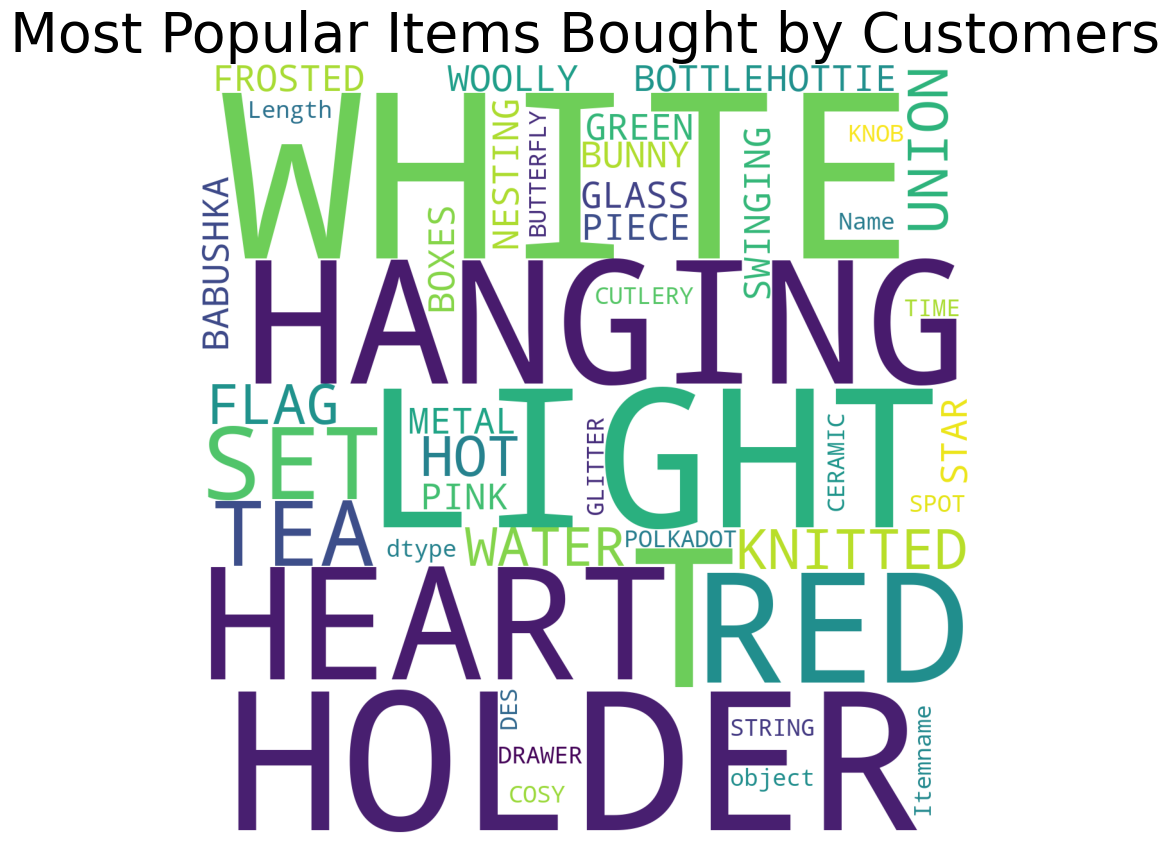

In [9]:

plt.rcParams['figure.figsize'] = (15, 10)
wordcloud = WordCloud(background_color = 'white', width = 1200,  height = 1200, min_font_size = 3).generate(str(df['Itemname']))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Most Popular Items Bought by Customers',fontsize = 40)
plt.show()

In [19]:
mostsoldprod = df.groupby(["Itemname"])["Quantity"].sum().reset_index().sort_values("Quantity", ascending = False)

mostsoldprod.reset_index(level = 0, inplace=True)
del mostsoldprod["index"]

mostsoldprod.head(10)

,Itemname,Quantity
0,WHITE HANGING HEART T-LIGHT HOLDER,1262
1,JUMBO BAG RED RETROSPOT,1008
2,LUNCH BAG RED RETROSPOT,1007
3,ASSORTED COLOUR BIRD ORNAMENT,840
4,HEART OF WICKER LARGE,726
5,SET OF 3 CAKE TINS PANTRY DESIGN,712
6,NATURAL SLATE HEART CHALKBOARD,706
7,JUMBO SHOPPER VINTAGE RED PAISLEY,667
8,RED HANGING HEART T-LIGHT HOLDER,666
9,LUNCH BAG SUKI DESIGN,661


In [44]:
plt.rcParams['figure.figsize'] = (10, 10)
top5 = mostsoldprod.loc[0:5,["Itemname", "Quantity"]].sort_values("Quantity", ascending = True)


top5.plot(kind = "barh", x = "Itemname", align = "center")
plt.ylabel('Products')
plt.xlabel('Quantities Sold')
plt.title('Most Quantities of Products Sold')
plt.show()

NameError: name 'mostsoldprod' is not defined

In [23]:
print("In Training data:")
pd.DataFrame({'unique count': [len(df.CustomerID.unique()),
                               len(df.Itemname.unique())]},
              index=['Member_number', 'itemDescription'])

In Training data:


,unique count
Member_number,1391
itemDescription,2523


In [43]:
data_test[data_test['Quantity']<=0].head()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,cost


There are no unrealistic values of 'Quantity'

Removes blank spaces 

In [ ]:
df['Description'] = df['Description'].str.strip()

Converts to string

In [ ]:
df['InvoiceNo']   = df['InvoiceNo'].astype('str')

Create Market Basket

In [ ]:
basket = df.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().fillna(0)
basket

In [4]:
transactions = df.groupby(['CustomerID'])['Itemname'].apply(list)
transactions.head()

CustomerID
12347    [ALARM CLOCK BAKELIKE GREEN, CAMOUFLAGE EAR MU...
12350            [PINK/PURPLE RETRO RADIO, RETRO MOD TRAY]
12352    [WELCOME  WOODEN BLOCK LETTERS, LOVE BUILDING ...
12356                           [RED RETROSPOT CAKE STAND]
12362    [STRAWBERRY LUNCH BOX WITH CUTLERY, FELTCRAFT ...
Name: Itemname, dtype: object

One Hot Encoding

In [22]:
data_train['value'] = 1
#creating the user-item interaction matrix
grocery_pivot = data_train.pivot_table(index='CustomerID',\
                                            columns='Itemname',\
                                            values='value')
grocery_pivot = grocery_pivot.fillna(0)

# Display first two rows of the groupby data frame
grocery_pivot.head()

Itemname,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,...,YULETIDE IMAGES S/6 PAPER BOXES,ZINC FINISH 15CM PLANTER POTS,ZINC HEART LATTICE 2 WALL PLANTER,ZINC HEART LATTICE CHARGER LARGE,ZINC HEART LATTICE CHARGER SMALL,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC HEART LATTICE TRAY OVAL,ZINC METAL HEART DECORATION,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12356,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
data_test.head()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,cost
0,544398.0,JUMBO SHOPPER VINTAGE RED PAISLEY,1.0,18/02/2011 12:27,1.95,15311.0,1.95
1,544398.0,ZINC WILLIE WINKIE CANDLE STICK,4.0,18/02/2011 12:27,0.85,15311.0,3.40
2,544398.0,LOVE BUILDING BLOCK WORD,2.0,18/02/2011 12:27,5.95,15311.0,11.90
3,544398.0,HANGING FAIRY CAKE DECORATION,3.0,18/02/2011 12:27,2.10,15311.0,6.30
4,544398.0,RED HEART SHAPE LOVE BUCKET,1.0,18/02/2011 12:27,2.95,15311.0,2.95


In [24]:
groceries_test = pd.DataFrame(data_test.\
                              groupby(['CustomerID'])\
                              ['Itemname'].unique())
groceries_test.head()

,Itemname
CustomerID,
12352.0,"[DELUXE SEWING KIT, VINTAGE CREAM DOG FOOD CON..."
12361.0,"[ROUND SNACK BOXES SET OF4 WOODLAND, ROUND SNA..."
12415.0,"[BREAD BIN DINER STYLE PINK, BREAD BIN DINER S..."
12417.0,"[RED RETROSPOT SUGAR JAM BOWL, BOX OF 6 ASSORT..."
12423.0,"[ROUND SNACK BOXES SET OF 4 FRUITS, ROUND SNAC..."
